# PDAN8412 POE Part 1
## LSTM-RNN

Link:
https://archive.ics.uci.edu/dataset/454/victorian+era+authorship+attribution 

# Table of Contents  
**Setup Instructions**
- Installing tooling prerequisites
- Create the tf210 environment
- Install Python dependencies (GPU-ready)
- Register the Jupyter Kernel
- Configure Java for Spark
- Validate the GPU-enabled stack  


TODO:Complete

## Environment Overview (`tf210`)

This project runs inside a mamba-managed conda environment named `tf210`.  

Key bits:
- TensorFlow 2.10.0 with CUDA 11.2 / cuDNN 8.1 GPU acceleration
- `numpy<2` to satisfy TensorFlow 2.10 constraints
- `pyspark` + `findspark` (1.4 series) for Spark integration
- `pyarrow`/pandas for Parquet persistence


## Setup Instructions

### 1. Install tooling prerequisites
- **Python 3.10** (bundled with the `tf210` environment)
- **Adoptium JDK 17** (https://adoptium.net/) for PySpark
- NVIDIA driver compatible with CUDA 11.2
- VS Code + Python extension (optional but recommended)

If you have not enabled `mamba` yet, install it into the base Conda environment:
```bash
conda install -n base -c conda-forge mamba -y
```

### 2. Create the `tf210` environment
```bash
mamba create -n tf210 python=3.10 -y
conda activate tf210
mamba install -c conda-forge cudatoolkit=11.2 cudnn=8.1 -y
```

### 3. Install Python dependencies (GPU-ready)
```bash
pip install --upgrade pip
pip install -r requirements.txt
```
The requirements file pins `tensorflow==2.10.0`, `numpy<2`, and the Spark helpers (`pyspark`, `findspark==1.4.2`).

### 4. Register the Jupyter kernel
```bash
python -m ipykernel install --user --name tf210 --display-name "Python (tf210)"
```
Restart VS Code / Jupyter and pick the `tf210` kernel for this notebook.

### 5. Configure Java for Spark
Set `JAVA_HOME` to your Adoptium JDK 17 installation path.
```powershell
setx JAVA_HOME "C:\Program Files\Eclipse Adoptium\jdk-17.x.x.x-hotspot"
```
(Re-open PowerShell after running `setx`.)

### 6. Validate the GPU-enabled stack
```bash
python - <<'PY'
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
PY
```
You should see `2.10.0` and at least one GPU device in the output. If it returns an empty list, double-check your CUDA/cuDNN installation and driver version.


## Library Installs and Dataset Download

In [1]:
# all libraries contained inside a venv running on Python 3.10.8 and Adoptium JDK 17.0.16.8-hotspot
# Total venv file size ~5GB
!python -m pip install -r requirements.txt

In [2]:
# ensure dataset is present by using the helper script
!python scripts/ensure_dataset.py

All expected dataset files are already present. Nothing to do.


## Environment Setup

### Imports  
TODO: Add references and comments

In [ ]:

import json
import random
import re
import sys
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    top_k_accuracy_score,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize

import tensorflow as tf
from tensorflow.keras import callbacks, layers, mixed_precision, optimizers
from tensorflow.keras.layers import TextVectorization

from pyspark.sql import SparkSession
import pyspark.sql.functions as F

import warnings

warnings.filterwarnings("ignore")

pd.options.display.max_colwidth = 200
sns.set_theme(style="whitegrid")


### TensorFlow & Spark Setup

In [4]:

print("Python executable:", sys.executable)
print("TensorFlow version:", tf.__version__)

physical_gpus = tf.config.list_physical_devices('GPU')
if physical_gpus:
    print(f"GPUs detected: {[gpu.name for gpu in physical_gpus]}")
    for gpu in physical_gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except Exception as err:
            print(f"  Warning: could not enable memory growth for {gpu.name}: {err}")
    mixed_precision.set_global_policy('mixed_float16')
else:
    print("No GPUs detected; using CPU execution.")
    mixed_precision.set_global_policy('float32')

logical_devices = tf.config.list_logical_devices()
print(f"Logical devices: {[device.name for device in logical_devices]}")
print(f"Using mixed precision policy: {mixed_precision.global_policy().name}")

spark = SparkSession.builder \
    .appName("VictorianAuthorAttribution") \
    .config("spark.driver.memory", "16g") \
    .config("spark.driver.maxResultSize", "8g") \
    .getOrCreate()
spark.sparkContext.setLogLevel("WARN")
print(f"Spark version: {spark.version}")


Python executable: c:\Users\Nick\anaconda3\envs\tf210\python.exe
TensorFlow version: 2.10.0
GPUs detected: ['/physical_device:GPU:0']
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Laptop GPU, compute capability 8.6
Logical devices: ['/device:CPU:0', '/device:GPU:0']
Using mixed precision policy: mixed_float16
Spark version: 4.0.1


### Configuration

In [5]:

TEXT_COL = 'text'
AUTHOR_COL = 'author'

DATA_DIR = Path('data')
PROCESSED_DIR = DATA_DIR / 'processed'
ARTIFACTS_DIR = Path('artifacts')
FEATURES_DIR = ARTIFACTS_DIR / 'features'
MODELS_DIR = Path('models')
METRICS_DIR = Path('reports') / 'metrics'

for path in [PROCESSED_DIR, ARTIFACTS_DIR, FEATURES_DIR, MODELS_DIR, METRICS_DIR]:
    path.mkdir(parents=True, exist_ok=True)

TRAIN_CSV = DATA_DIR / 'Gungor_2018_VictorianAuthorAttribution_data-train.csv'
FEATURE_RANK_PATH = FEATURES_DIR / 'chi2_feature_ranking.csv'
TOP_TERMS_PATH = FEATURES_DIR / 'top_terms_per_class.json'
CLASS_COUNTS_PATH = ARTIFACTS_DIR / 'class_counts.csv'
LABEL_INDEX_PATH = ARTIFACTS_DIR / 'label_index.json'
RUN_CONFIG_PATH = ARTIFACTS_DIR / 'run_config.json'
VOCAB_PATH = ARTIFACTS_DIR / 'vocabulary.txt'
VAL_PREDICTIONS_PATH = ARTIFACTS_DIR / 'val_predictions.parquet'

compute_device = 'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'

RUN_CONFIG = {
    'seed': 86,
    'val_fraction': 0.10,
    'test_fraction': 0.10,
    'max_tokens': 25000,
    'sequence_length': 900,
    'embedding_dim': 256,
    'lstm_units': 192,
    'dropout_rate': 0.35,
    'batch_size': 64,
    'epochs': 15,
    'learning_rate': 1e-3,
    'callback_sample_size': 6000,
    'compute_device': compute_device,
}

print(json.dumps(RUN_CONFIG, indent=2))


{
  "seed": 86,
  "val_fraction": 0.1,
  "test_fraction": 0.1,
  "max_tokens": 25000,
  "sequence_length": 900,
  "embedding_dim": 256,
  "lstm_units": 192,
  "dropout_rate": 0.35,
  "batch_size": 64,
  "epochs": 15,
  "learning_rate": 0.001,
  "callback_sample_size": 6000,
  "compute_device": "GPU"
}


### Helper Utilities

In [6]:

NON_ALPHA_NUM_RE = re.compile(r"[^a-z0-9']+")
MULTISPACE_RE = re.compile(r"\s+")


def normalize_text_py(text: str) -> str:
    if not isinstance(text, str):
        text = '' if text is None else str(text)
    text = text.lower()
    text = NON_ALPHA_NUM_RE.sub(' ', text)
    text = MULTISPACE_RE.sub(' ', text)
    return text.strip()


def custom_standardization(input_text: tf.Tensor) -> tf.Tensor:
    lowercase = tf.strings.lower(input_text)
    cleaned = tf.strings.regex_replace(lowercase, r"[^a-z0-9']+", ' ')
    cleaned = tf.strings.regex_replace(cleaned, r"\s+", ' ')
    return tf.strings.strip(cleaned)


def set_random_seeds(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


def describe_counts(frame: pd.DataFrame, label: str) -> pd.Series:
    counts = frame['author_index'].value_counts().sort_index()
    print(f"{label:<6} -> {len(frame):,} rows | class min={counts.min()}, max={counts.max()}, median={counts.median()}")
    return counts


def compute_inverse_sqrt_class_weights(counts: pd.Series) -> dict:
    inv_sqrt = 1.0 / np.sqrt(counts.replace(0, np.nan))
    inv_sqrt = inv_sqrt.replace(np.nan, 0.0)
    normalized = inv_sqrt / inv_sqrt[inv_sqrt > 0].mean()
    return {int(idx): float(weight) for idx, weight in normalized.items()}


def plot_conf_matrix(y_true, y_pred, labels, title, figsize=(16, 14)):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=False, fmt='d', cmap='Reds', ax=ax,
                xticklabels=labels, yticklabels=labels)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title(title)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    return cm


def plot_learning_curves(history_obj, metrics_cb, title_prefix=""):
    epochs = range(1, len(history_obj.history['loss']) + 1)
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].plot(epochs, history_obj.history['loss'], label='Train')
    axes[0].plot(epochs, history_obj.history['val_loss'], label='Validation')
    axes[0].set_title(f"{title_prefix} Loss")
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(epochs, history_obj.history['sparse_categorical_accuracy'], label='Train')
    axes[1].plot(epochs, history_obj.history['val_sparse_categorical_accuracy'], label='Validation')
    axes[1].set_title(f"{title_prefix} Accuracy")
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    axes[2].plot(epochs, metrics_cb.history['train_macro_recall'], label='Train')
    axes[2].plot(epochs, metrics_cb.history['val_macro_recall'], label='Validation')
    axes[2].set_title(f"{title_prefix} Macro Recall")
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Macro Recall')
    axes[2].set_ylim(0, 1)
    axes[2].legend()

    plt.tight_layout()
    plt.show()


def macro_roc_curve(y_true: np.ndarray, y_prob: np.ndarray, num_classes: int):
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    fpr = dict()
    tpr = dict()
    for idx in range(num_classes):
        fpr[idx], tpr[idx], _ = roc_curve(y_true_bin[:, idx], y_prob[:, idx])
    all_fpr = np.unique(np.concatenate([fpr[idx] for idx in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for idx in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[idx], tpr[idx])
    mean_tpr /= num_classes
    roc_auc = auc(all_fpr, mean_tpr)
    return all_fpr, mean_tpr, roc_auc


## Data Loading and EDA

### Ingest Training Data with PySpark

In [7]:

read_options = {
    'header': 'true',
    'inferSchema': 'true',
    'multiLine': 'true',
    'escape': '\\',
    'quote': '"',
}

df_spark_raw = spark.read.options(**read_options).csv(str(TRAIN_CSV))
print(f"Raw rows loaded: {df_spark_raw.count():,}")

cleaned = (
    df_spark_raw
    .withColumn(TEXT_COL, F.trim(F.regexp_replace(F.col(TEXT_COL), r"\s+", ' ')))
    .withColumn(AUTHOR_COL, F.col(AUTHOR_COL).cast('string'))
    .filter(F.col(TEXT_COL).isNotNull())
    .filter(F.length(TEXT_COL) > 0)
    .withColumn('token_array', F.split(F.col(TEXT_COL), r"\s+"))
    .withColumn('token_count', F.size(F.col('token_array')))
    .withColumn('unique_token_count', F.size(F.array_distinct(F.col('token_array'))))
    .withColumn('text_length', F.length(F.col(TEXT_COL)))
    .withColumn('digit_count', F.length(F.regexp_replace(F.col(TEXT_COL), r"[^0-9]", '')))
    .withColumn('punctuation_count', F.length(F.regexp_replace(F.col(TEXT_COL), r"[A-Za-z0-9\s]", '')))
    .withColumn('avg_word_length', F.when(F.col('token_count') > 0, F.col('text_length') / F.col('token_count')).otherwise(0.0))
    .withColumn('digit_density', F.when(F.col('text_length') > 0, F.col('digit_count') / F.col('text_length')).otherwise(0.0))
    .withColumn('punctuation_density', F.when(F.col('text_length') > 0, F.col('punctuation_count') / F.col('text_length')).otherwise(0.0))
)

df_spark = cleaned.cache()
row_count = df_spark.count()
unique_authors = df_spark.select(F.col(AUTHOR_COL)).distinct().count()
print(f"Post-clean rows: {row_count:,} | Unique authors: {unique_authors}")


Raw rows loaded: 53,678
Post-clean rows: 53,678 | Unique authors: 45


### Data Schema Investigation

In [8]:

df_spark.printSchema()
print("Sample records:")
df_spark.select(TEXT_COL, AUTHOR_COL, 'text_length', 'token_count').show(5, truncate=100)


root
 |-- text: string (nullable = true)
 |-- author: string (nullable = true)
 |-- token_array: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- token_count: integer (nullable = true)
 |-- unique_token_count: integer (nullable = true)
 |-- text_length: integer (nullable = true)
 |-- digit_count: integer (nullable = true)
 |-- punctuation_count: integer (nullable = true)
 |-- avg_word_length: double (nullable = true)
 |-- digit_density: double (nullable = true)
 |-- punctuation_density: double (nullable = true)

Sample records:
+----------------------------------------------------------------------------------------------------+------+-----------+-----------+
|                                                                                                text|author|text_length|token_count|
+----------------------------------------------------------------------------------------------------+------+-----------+-----------+
|ou have time to listen i will give

### Statistical Overview

In [9]:

stat_columns = ['text_length', 'token_count', 'unique_token_count', 'avg_word_length', 'digit_density', 'punctuation_density']
summary_pdf = df_spark.select(*stat_columns).describe().toPandas()
print("Descriptive statistics for key features:")
display(summary_pdf)

quantiles = df_spark.approxQuantile('token_count', [0.1, 0.25, 0.5, 0.75, 0.9, 0.95], 0.01)
print(dict(zip(['p10', 'p25', 'p50', 'p75', 'p90', 'p95'], [round(q, 2) for q in quantiles])))


Descriptive statistics for key features:


,summary,text_length,token_count,unique_token_count,avg_word_length,digit_density,punctuation_density
0,count,53678,53678,53678,53678,53678,53678
1,mean,4941.966913819442,1000.0,400.47783076865755,4.941966913819464,0.0,0.0019681099769995295
2,stddev,249.79725188625955,0.0,33.837493547396576,0.2497972518862579,0.0,0.003204549887069137
3,min,2285,1000,104,2.285,0.0,0.0
4,max,5759,1000,529,5.759,0.0,0.14266958424507659


{'p10': 1000.0, 'p25': 1000.0, 'p50': 1000.0, 'p75': 1000.0, 'p90': 1000.0, 'p95': 1000.0}


### Distribution of Author Documents

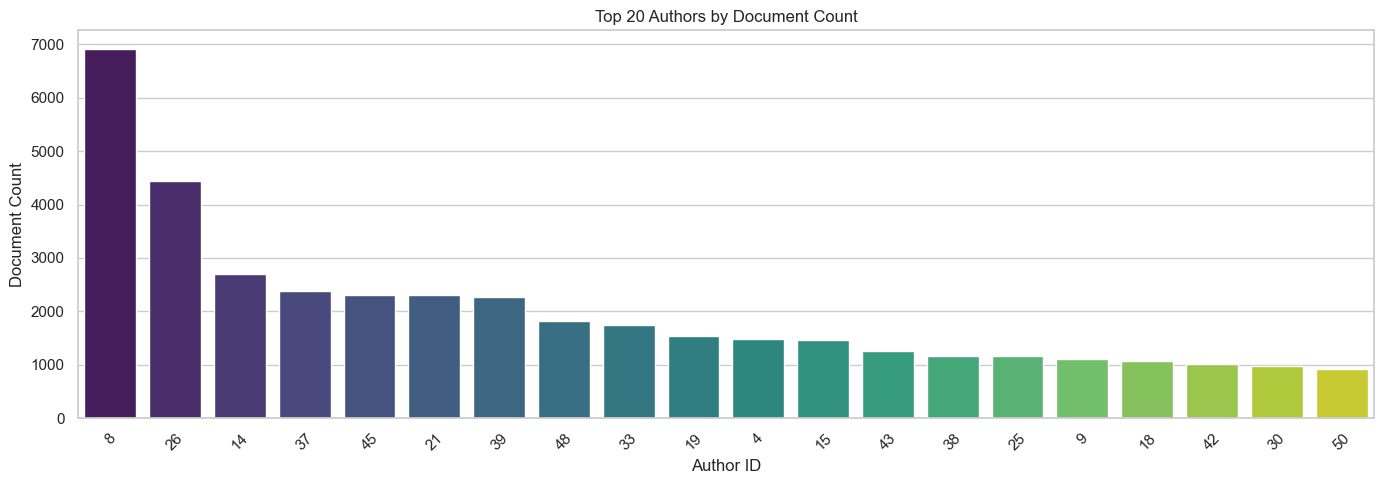

In [10]:

author_counts_pd = (
    df_spark.groupBy(AUTHOR_COL)
            .count()
            .orderBy(F.desc('count'))
            .toPandas()
)
author_counts_pd['author'] = author_counts_pd[AUTHOR_COL].astype(int).astype(str)
author_counts_pd = author_counts_pd.sort_values('count', ascending=False).reset_index(drop=True)

plt.figure(figsize=(14, 5))
sns.barplot(data=author_counts_pd.head(20), x='author', y='count', palette='viridis')
plt.title('Top 20 Authors by Document Count')
plt.xlabel('Author ID')
plt.ylabel('Document Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Text Content Analysis

In [11]:

top_tokens_pd = (
    df_spark.select(F.explode('token_array').alias('token'))
            .where(F.length('token') >= 3)
            .groupBy('token')
            .count()
            .orderBy(F.desc('count'))
            .limit(25)
            .toPandas()
)
print("Most frequent tokens (length >=3):")
display(top_tokens_pd)

avg_length_by_author = (
    df_spark.groupBy(AUTHOR_COL)
            .agg(
                F.avg('text_length').alias('avg_length'),
                F.avg('token_count').alias('avg_tokens'),
                F.avg('avg_word_length').alias('avg_word_len')
            )
            .orderBy(F.desc('avg_length'))
            .toPandas()
)
print("Authors with longest average documents:")
display(avg_length_by_author.head(10))

sample_rows = (
    df_spark.select(TEXT_COL, AUTHOR_COL)
            .orderBy(F.rand(seed=RUN_CONFIG['seed']))
            .limit(5)
            .toPandas()
)
print("Sample excerpts:")
display(sample_rows)


Most frequent tokens (length >=3):


,token,count
0,the,3142432
1,and,1898968
2,that,702345
3,was,674696
4,his,529741
5,you,489528
6,with,463788
7,her,463259
8,for,433169
9,had,406999


Authors with longest average documents:


,author,avg_length,avg_tokens,avg_word_len
0,41,5207.773875,1000.0,5.207774
1,28,5163.811665,1000.0,5.163812
2,35,5128.675266,1000.0,5.128675
3,37,5128.599916,1000.0,5.128600
4,11,5128.279373,1000.0,5.128279
5,24,5118.992105,1000.0,5.118992
6,20,5107.366269,1000.0,5.107366
7,29,5080.234109,1000.0,5.080234
8,32,5077.391181,1000.0,5.077391
9,16,5048.737705,1000.0,5.048738


Sample excerpts:


,text,author
0,him as it had been in spite of had made him an advocate with her of her own and his friend s interests he had not used such of speech as the occasion demanded and as he had intended to use he had ...,25
1,an in affairs of the heart by reason of there having existed a mr who played short and was supposed to have been of her my private opinion is that this was entirely a assumption and that was altog...,8
2,rags of last year s offering rewards for drowned men fluttering above i i the personal history and experience high water mark led down through the and to the ebb tide there was a story that one of...,8
3,little beggars � gone all gone where she had stretched was a bloody depression in the soft earth all of a yard in and around the edges a few scattered hairs i measured three feet on the snow threw...,21
4,why doesn t my governor � if it comes to that � give all he s got to the poor why doesn t he cast his last shilling into the treasury like the poor widow in the � which was a pretty example of pol...,25


### Convert to pandas for EDA & Modeling

In [ ]:

columns_to_drop = ['token_array']
df_spark_pd_ready = df_spark.drop(*columns_to_drop)
pdf_full = df_spark_pd_ready.toPandas()
pdf_full[AUTHOR_COL] = pdf_full[AUTHOR_COL].astype(str)
print(f"Converted to pandas dataframe: {pdf_full.shape}")

Converted to pandas dataframe: (53678, 10)


### Histogram of Text Lengths

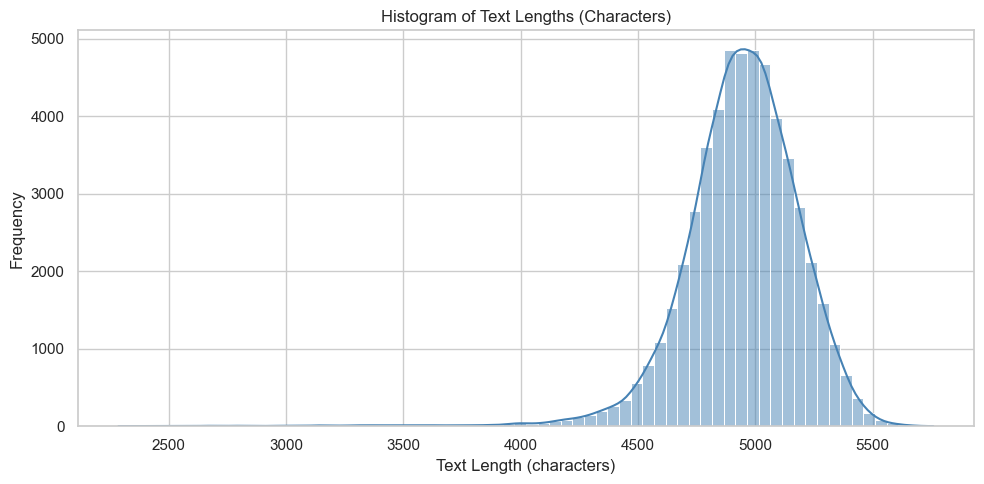

In [13]:

plt.figure(figsize=(10, 5))
sns.histplot(pdf_full['text_length'], bins=70, kde=True, color='steelblue')
plt.title('Histogram of Text Lengths (Characters)')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


### Boxplots of Text Length by Author

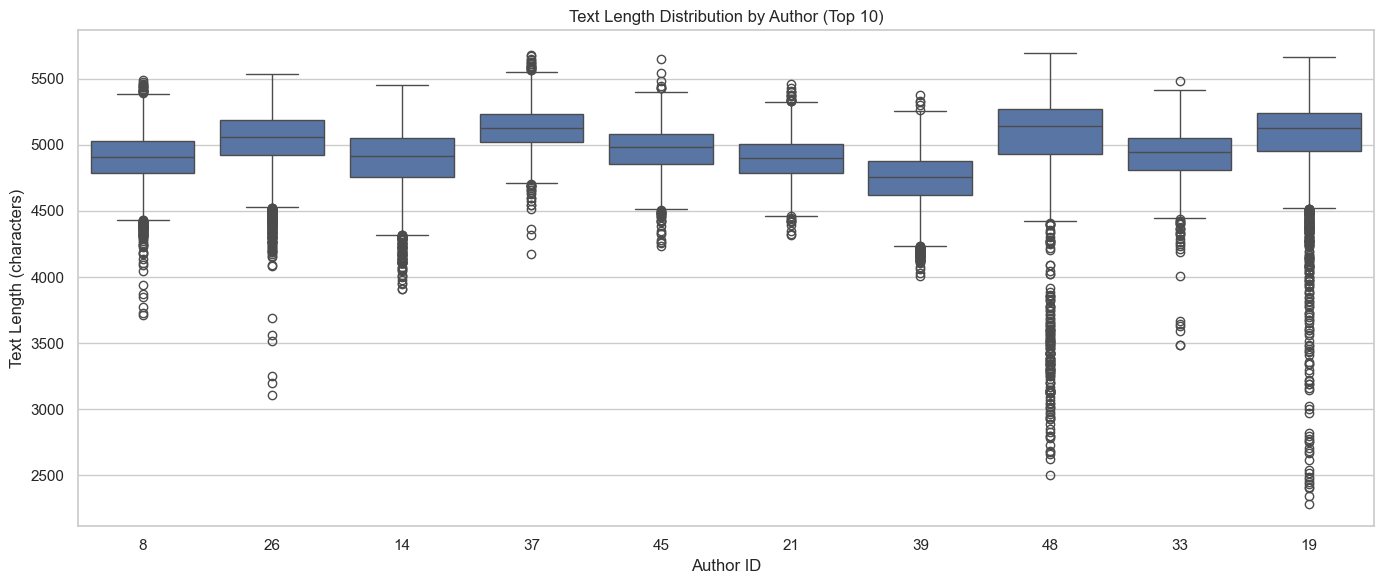

In [14]:

top_authors = pdf_full[AUTHOR_COL].value_counts().head(10).index.tolist()
plt.figure(figsize=(14, 6))
sns.boxplot(data=pdf_full[pdf_full[AUTHOR_COL].isin(top_authors)], x=AUTHOR_COL, y='text_length', order=top_authors)
plt.title('Text Length Distribution by Author (Top 10)')
plt.xlabel('Author ID')
plt.ylabel('Text Length (characters)')
plt.tight_layout()
plt.show()


### Violin and Swarm Plots

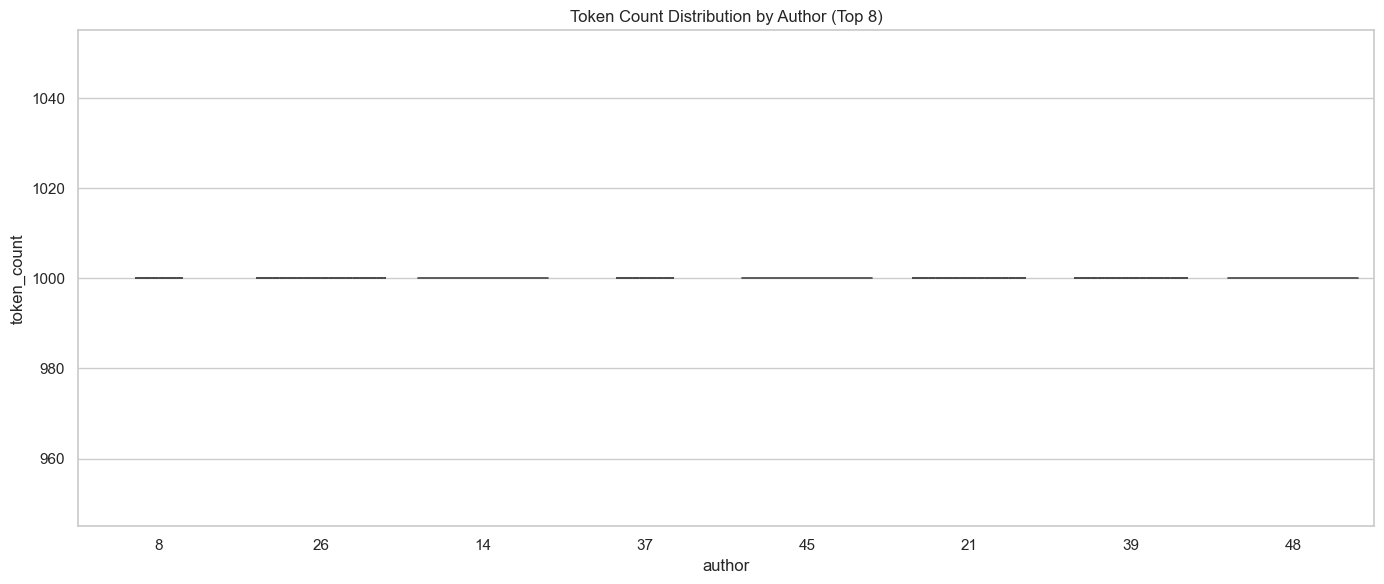

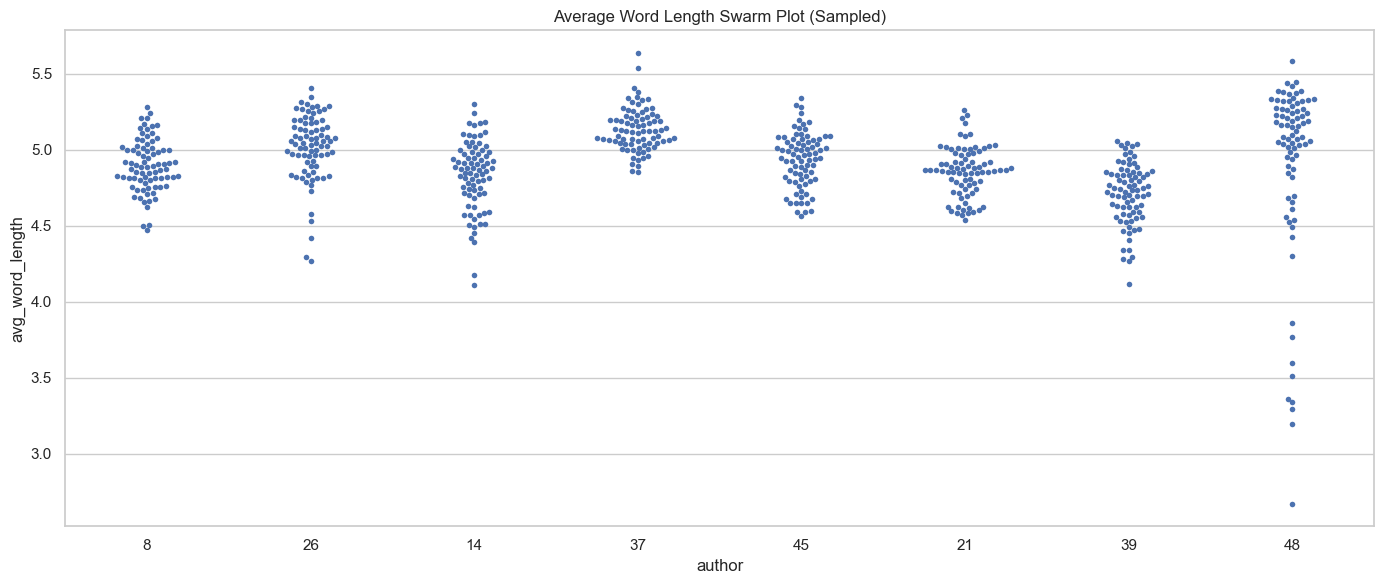

In [15]:

top_authors_violin = pdf_full[AUTHOR_COL].value_counts().head(8).index.tolist()
subset_violin = pdf_full[pdf_full[AUTHOR_COL].isin(top_authors_violin)].copy()
plt.figure(figsize=(14, 6))
sns.violinplot(data=subset_violin, x=AUTHOR_COL, y='token_count', order=top_authors_violin, inner='quartile', cut=0)
plt.title('Token Count Distribution by Author (Top 8)')
plt.tight_layout()
plt.show()

swarm_sample = subset_violin.groupby(AUTHOR_COL).apply(lambda df: df.sample(min(len(df), 80), random_state=RUN_CONFIG['seed'])).reset_index(drop=True)
plt.figure(figsize=(14, 6))
sns.swarmplot(data=swarm_sample, x=AUTHOR_COL, y='avg_word_length', order=top_authors_violin, size=4)
plt.title('Average Word Length Swarm Plot (Sampled)')
plt.tight_layout()
plt.show()


### Data Quality Assurance

In [16]:

pdf_full['text_clean'] = pdf_full[TEXT_COL].apply(normalize_text_py)
null_counts = pdf_full[[TEXT_COL, AUTHOR_COL]].isna().sum()
duplicate_raw = pdf_full.duplicated(subset=[TEXT_COL]).sum()
duplicate_clean = pdf_full.duplicated(subset=['text_clean']).sum()
short_texts = (pdf_full['token_count'] < 20).sum()
print("Null counts:", null_counts)
print(f"Exact duplicate texts: {duplicate_raw:,}")
print(f"Duplicate after normalization: {duplicate_clean:,}")
print(f"Documents with <20 tokens: {short_texts:,}")


Null counts: text      0
author    0
dtype: int64
Exact duplicate texts: 0
Duplicate after normalization: 0
Documents with <20 tokens: 0


### Normalise Text & Deduplicate

In [17]:

df_clean = pdf_full[~pdf_full.duplicated(subset=['text_clean'])].copy()
df_clean = df_clean[df_clean['text_clean'].str.len() > 0].reset_index(drop=True)

unique_authors_sorted = sorted(df_clean[AUTHOR_COL].unique(), key=lambda x: int(x))
author_to_index = {author: idx for idx, author in enumerate(unique_authors_sorted)}
index_to_author = {idx: author for author, idx in author_to_index.items()}

df_clean['author_index'] = df_clean[AUTHOR_COL].map(author_to_index).astype('int32')
set_random_seeds(RUN_CONFIG['seed'])

print(f"Cleaned dataframe rows: {len(df_clean):,} | Authors: {len(author_to_index)}")


Cleaned dataframe rows: 53,678 | Authors: 45


### Stratified Train/Validation/Test Splits

In [18]:

val_fraction = RUN_CONFIG['val_fraction']
test_fraction = RUN_CONFIG['test_fraction']
temp_fraction = val_fraction + test_fraction

train_df, temp_df = train_test_split(
    df_clean,
    test_size=temp_fraction,
    stratify=df_clean['author_index'],
    random_state=RUN_CONFIG['seed'],
)

if temp_fraction > 0:
    relative_test = test_fraction / temp_fraction
    val_df, test_df = train_test_split(
        temp_df,
        test_size=relative_test,
        stratify=temp_df['author_index'],
        random_state=RUN_CONFIG['seed'],
    )
else:
    val_df, test_df = temp_df.copy(), pd.DataFrame(columns=df_clean.columns)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"Split sizes -> train: {len(train_df):,}, val: {len(val_df):,}, test: {len(test_df):,}")

all_indices = pd.Index(range(len(author_to_index)))
train_counts = train_df['author_index'].value_counts().reindex(all_indices, fill_value=0).sort_index()
val_counts = val_df['author_index'].value_counts().reindex(all_indices, fill_value=0).sort_index()
test_counts = test_df['author_index'].value_counts().reindex(all_indices, fill_value=0).sort_index()

split_columns = [TEXT_COL, 'text_clean', AUTHOR_COL, 'author_index', 'text_length', 'token_count', 'unique_token_count', 'avg_word_length', 'digit_density', 'punctuation_density']

for name, frame in {'closed_train': train_df, 'closed_val': val_df, 'closed_test': test_df}.items():
    output_path = PROCESSED_DIR / f"{name}.parquet"
    frame[split_columns].to_parquet(output_path, index=False)
    print(f"Saved {name} -> {output_path}")

counts_total = train_counts + val_counts + test_counts
counts_df = pd.DataFrame({
    'author_index': counts_total.index.astype(int),
    'author': [index_to_author[int(idx)] for idx in counts_total.index],
    'train_count': train_counts.values.astype(int),
    'val_count': val_counts.values.astype(int),
    'test_count': test_counts.values.astype(int),
    'total_count': counts_total.values.astype(int),
})
counts_df.to_csv(CLASS_COUNTS_PATH, index=False)
print(f"Class counts saved -> {CLASS_COUNTS_PATH}")

LABEL_INDEX_PATH.write_text(json.dumps({
    'author_to_index': author_to_index,
    'index_to_author': {str(idx): str(author) for idx, author in index_to_author.items()},
}, indent=2))
print(f"Label index saved -> {LABEL_INDEX_PATH}")

RUN_CONFIG['train_size'] = int(len(train_df))
RUN_CONFIG['val_size'] = int(len(val_df))
RUN_CONFIG['test_size'] = int(len(test_df))


Split sizes -> train: 42,942, val: 5,368, test: 5,368
Saved closed_train -> data\processed\closed_train.parquet
Saved closed_val -> data\processed\closed_val.parquet
Saved closed_test -> data\processed\closed_test.parquet
Class counts saved -> artifacts\class_counts.csv
Label index saved -> artifacts\label_index.json


### Per Author Document Counts in Training Set

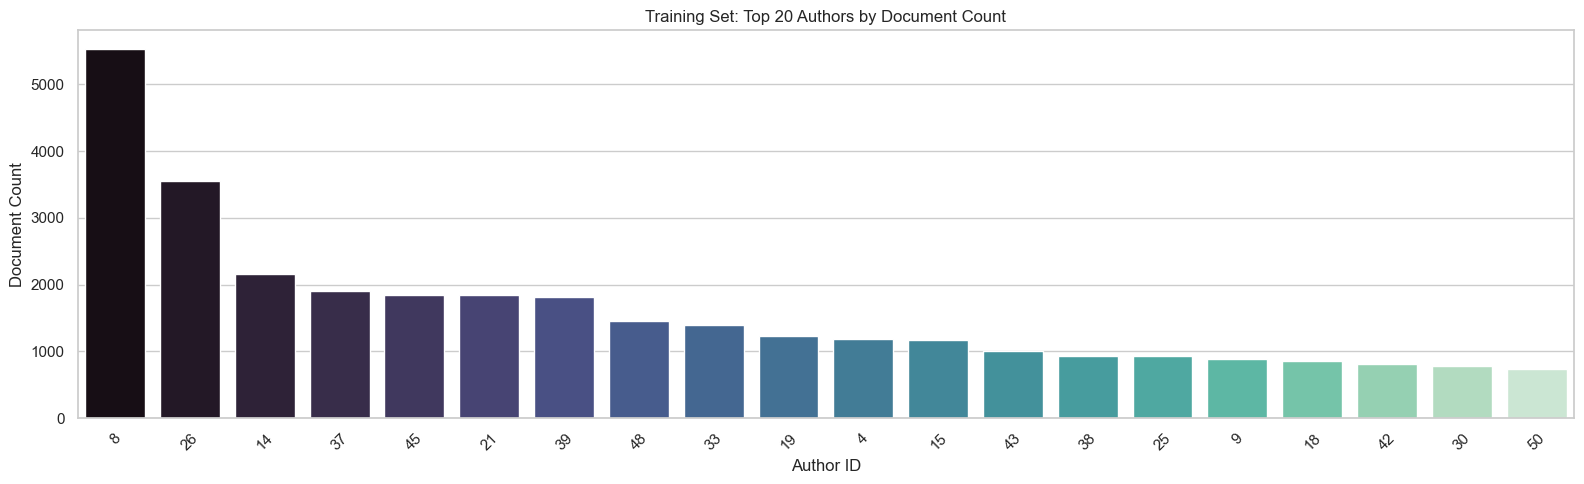

In [19]:

train_author_counts = train_df[AUTHOR_COL].value_counts().sort_values(ascending=False)
plt.figure(figsize=(16, 5))
sns.barplot(x=train_author_counts.index[:20], y=train_author_counts.values[:20], palette='mako')
plt.title('Training Set: Top 20 Authors by Document Count')
plt.xlabel('Author ID')
plt.ylabel('Document Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Sequence Length Diagnostics

Token length percentiles:
  p50 : 994.0
  p75 : 997.0
  p90 : 999.0
  p95 : 1000.0
  p99 : 1000.0


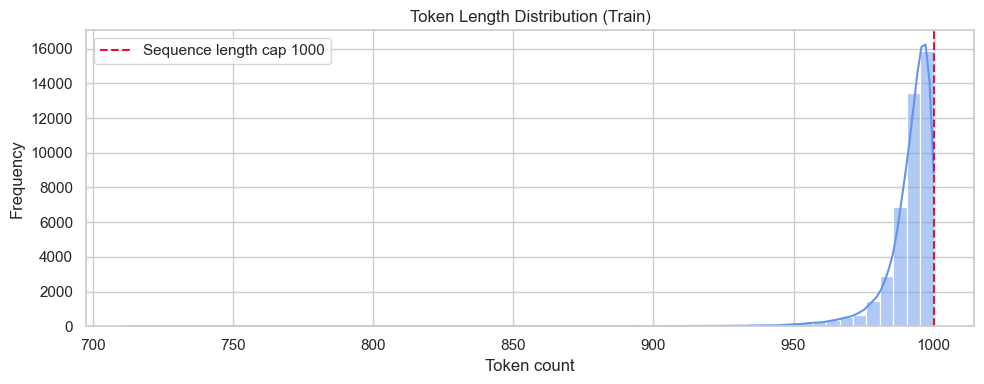

In [20]:

train_token_lengths = train_df['text_clean'].str.split().str.len()
percentiles = {p: float(np.percentile(train_token_lengths, p)) for p in (50, 75, 90, 95, 99)}
print("Token length percentiles:")
for p, value in percentiles.items():
    print(f"  p{p:<3}: {value:.1f}")
recommended_seq_len = int(min(1200, max(400, percentiles[95])))
RUN_CONFIG['sequence_length'] = recommended_seq_len
RUN_CONFIG['sequence_length_stats'] = percentiles

plt.figure(figsize=(10, 4))
sns.histplot(train_token_lengths, bins=60, kde=True, color='cornflowerblue')
plt.axvline(recommended_seq_len, color='crimson', linestyle='--', label=f'Sequence length cap {recommended_seq_len}')
plt.title('Token Length Distribution (Train)')
plt.xlabel('Token count')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


## Data Preprocessing

### Text Vectorization Setup

In [21]:

set_random_seeds(RUN_CONFIG['seed'])

vectorizer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=RUN_CONFIG['max_tokens'],
    output_mode='int',
    output_sequence_length=RUN_CONFIG['sequence_length'],
)

text_ds = tf.data.Dataset.from_tensor_slices(train_df['text_clean'].values).batch(1024)
vectorizer.adapt(text_ds)

vocab = vectorizer.get_vocabulary()
print(f"Vectorizer fitted -> vocabulary size {len(vocab):,}")
VOCAB_PATH.write_text(' '.join(vocab), encoding='utf-8')
print(f"Vocabulary saved -> {VOCAB_PATH}")

RUN_CONFIG['vocab_size'] = int(len(vocab))
RUN_CONFIG_PATH.write_text(json.dumps(RUN_CONFIG, indent=2))


Vectorizer fitted -> vocabulary size 9,979
Vocabulary saved -> artifacts\vocabulary.txt


509

### Neural Network Utilities

In [22]:

def make_dataset(texts: np.ndarray, labels: np.ndarray, batch_size: int, shuffle: bool = False):
    ds = tf.data.Dataset.from_tensor_slices((texts, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(texts), seed=RUN_CONFIG['seed'])
    ds = ds.batch(batch_size)
    ds = ds.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.prefetch(tf.data.AUTOTUNE)


class MetricsCallback(callbacks.Callback):
    def __init__(self, train_texts, train_labels, val_texts, val_labels, batch_size):
        super().__init__()
        rng = np.random.default_rng(RUN_CONFIG['seed'])
        sample_size = min(RUN_CONFIG['callback_sample_size'], len(train_texts))
        self.train_indices = rng.choice(len(train_texts), size=sample_size, replace=False)
        self.train_texts = tf.constant(train_texts[self.train_indices])
        self.train_labels = np.array(train_labels[self.train_indices])
        self.val_texts = tf.constant(val_texts)
        self.val_labels = np.array(val_labels)
        self.batch_size = batch_size
        self.history = {
            'train_macro_f1': [],
            'val_macro_f1': [],
            'train_macro_recall': [],
            'val_macro_recall': [],
        }
        self.best_macro_f1 = 0.0

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        train_vectors = vectorizer(self.train_texts)
        val_vectors = vectorizer(self.val_texts)

        train_probs = self.model.predict(train_vectors, verbose=0, batch_size=self.batch_size)
        val_probs = self.model.predict(val_vectors, verbose=0, batch_size=self.batch_size)

        train_preds = train_probs.argmax(axis=1)
        val_preds = val_probs.argmax(axis=1)

        train_macro_f1 = f1_score(self.train_labels, train_preds, average='macro')
        val_macro_f1 = f1_score(self.val_labels, val_preds, average='macro')
        train_macro_recall = recall_score(self.train_labels, train_preds, average='macro')
        val_macro_recall = recall_score(self.val_labels, val_preds, average='macro')

        self.history['train_macro_f1'].append(float(train_macro_f1))
        self.history['val_macro_f1'].append(float(val_macro_f1))
        self.history['train_macro_recall'].append(float(train_macro_recall))
        self.history['val_macro_recall'].append(float(val_macro_recall))

        logs['val_macro_f1'] = val_macro_f1
        logs['val_macro_recall'] = val_macro_recall

        if val_macro_f1 > self.best_macro_f1:
            self.best_macro_f1 = float(val_macro_f1)
        print(f"Epoch {epoch + 1}: val_macro_f1={val_macro_f1:.4f}, val_macro_recall={val_macro_recall:.4f}")


def build_bilstm_model(vocab_size: int, sequence_length: int, num_classes: int) -> tf.keras.Model:
    inputs = layers.Input(shape=(sequence_length,), dtype='int32', name='token_ids')
    x = layers.Embedding(vocab_size, RUN_CONFIG['embedding_dim'], mask_zero=True)(inputs)
    x = layers.SpatialDropout1D(0.2)(x)
    x = layers.Bidirectional(layers.LSTM(RUN_CONFIG['lstm_units'], return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(RUN_CONFIG['lstm_units'] // 2, return_sequences=True))(x)
    avg_pool = layers.GlobalAveragePooling1D()(x)
    max_pool = layers.GlobalMaxPooling1D()(x)
    x = layers.concatenate([avg_pool, max_pool])
    x = layers.LayerNormalization()(x)
    x = layers.Dropout(RUN_CONFIG['dropout_rate'])(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(RUN_CONFIG['dropout_rate'])(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='closed_set_bilstm')
    optimizer = optimizers.Adam(learning_rate=RUN_CONFIG['learning_rate'], clipnorm=1.0)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'],
    )
    return model


### Prepare Datasets & Class Weights

In [23]:

train_texts = train_df['text_clean'].to_numpy()
val_texts = val_df['text_clean'].to_numpy()
test_texts = test_df['text_clean'].to_numpy()

train_labels = train_df['author_index'].to_numpy()
val_labels = val_df['author_index'].to_numpy()
test_labels = test_df['author_index'].to_numpy()

train_ds = make_dataset(train_texts, train_labels, RUN_CONFIG['batch_size'], shuffle=True)
val_ds = make_dataset(val_texts, val_labels, RUN_CONFIG['batch_size'], shuffle=False)
test_ds = make_dataset(test_texts, test_labels, RUN_CONFIG['batch_size'], shuffle=False)

class_weight_series = train_df['author_index'].value_counts().reindex(all_indices, fill_value=0).sort_index()
class_weights_dict = compute_inverse_sqrt_class_weights(class_weight_series)
print(f"Class weight range: {min(class_weights_dict.values()):.3f} -> {max(class_weights_dict.values()):.3f}")

NUM_CLASSES = len(author_to_index)
LABELS_ORDERED = [index_to_author[idx] for idx in range(NUM_CLASSES)]


Class weight range: 0.332 -> 2.041


## Feature Engineering

### Feature Selection with TF-IDF Chi-Square

In [24]:

text_vectorizer_full = TfidfVectorizer(max_features=60000, ngram_range=(1, 2), sublinear_tf=True)
X_train_tfidf = text_vectorizer_full.fit_transform(train_df['text_clean'])
selector_k = min(30000, X_train_tfidf.shape[1])
chi2_selector = SelectKBest(chi2, k=selector_k)
chi2_selector.fit(X_train_tfidf, train_df['author_index'])

feature_scores = pd.DataFrame({
    'feature': text_vectorizer_full.get_feature_names_out(),
    'chi2': chi2_selector.scores_,
    'pvalue': chi2_selector.pvalues_,
}).sort_values('chi2', ascending=False)
feature_scores.to_csv(FEATURE_RANK_PATH, index=False)
print(f"Chi-square feature ranking saved -> {FEATURE_RANK_PATH}")
print("Top 15 features by chi-square score:")
display(feature_scores.head(15))

RUN_CONFIG['chi2_k'] = int(selector_k)
RUN_CONFIG_PATH.write_text(json.dumps(RUN_CONFIG, indent=2))

sgd_probe = SGDClassifier(loss='log_loss', penalty='l2', alpha=1e-5, max_iter=1000, tol=1e-3, class_weight='balanced', random_state=RUN_CONFIG['seed'])
sgd_probe.fit(X_train_tfidf, train_df['author_index'])
top_terms = {}
coef_matrix = sgd_probe.coef_
feature_names = text_vectorizer_full.get_feature_names_out()
for class_idx in range(NUM_CLASSES):
    indices = np.argsort(coef_matrix[class_idx])[-15:][::-1]
    top_terms[index_to_author[class_idx]] = [feature_names[i] for i in indices]
TOP_TERMS_PATH.write_text(json.dumps(top_terms, indent=2))
print(f"Top terms per class saved -> {TOP_TERMS_PATH}")


Chi-square feature ranking saved -> artifacts\features\chi2_feature_ranking.csv
Top 15 features by chi-square score:


,feature,chi2,pvalue
47580,the idiot,2258.480256,0.000000e+00
32809,of arc,1756.363878,0.000000e+00
59751,young america,1490.868090,7.704606e-284
11496,de claim,1214.632538,1.010465e-225
23001,idiot,1014.502824,6.655481e-184
13869,england tale,943.704974,3.454483e-169
26257,lady life,941.893250,8.209315e-169
28561,mark twain,881.360907,2.846557e-156
25614,john marvel,879.540269,6.774108e-156
13759,enchanted type,833.634798,2.048403e-146


Top terms per class saved -> artifacts\features\top_terms_per_class.json


## Model Training

### Initialise Results Container

In [25]:
MODEL_RESULTS = []
BASELINE_ROC_DATA = None
BILSTM_ROC_DATA = None

### Baseline: TF-IDF + Stylometric SGDClassifier  
Note: CPU only with sklearn

Validation classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        91
           1       0.53      0.95      0.68        38
           2       1.00      0.90      0.95        21
           3       0.98      0.82      0.89       149
           4       0.81      0.95      0.88        41
           5       0.99      0.95      0.97       691
           6       1.00      0.99      1.00       111
           7       1.00      0.99      0.99        76
           8       0.82      0.79      0.81        39
           9       1.00      0.97      0.98        63
          10       1.00      0.94      0.97        48
          11       0.98      0.99      0.98       269
          12       1.00      0.99      1.00       146
          13       0.94      0.94      0.94        18
          14       0.93      0.94      0.93        66
          15       0.93      0.98      0.95       108
          16       0.83      0.94      0.88    

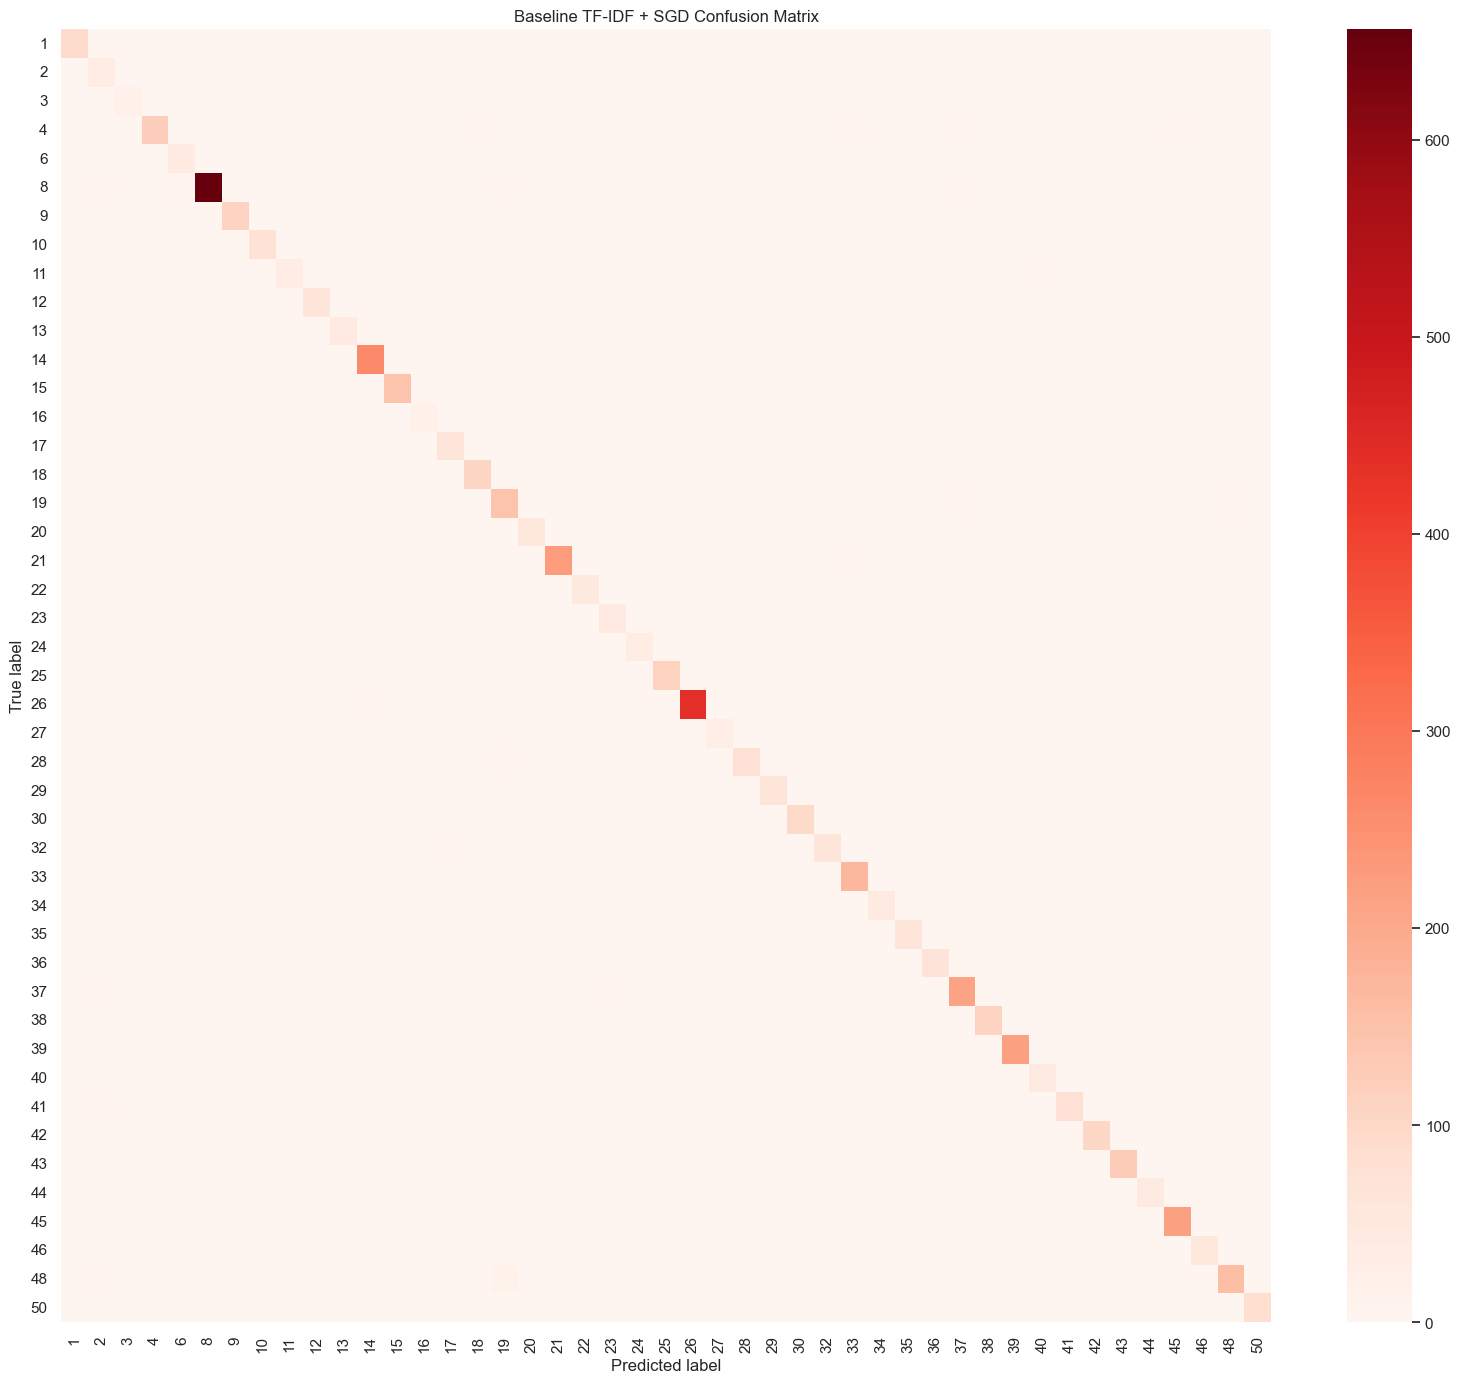

Baseline metrics saved -> reports\metrics\baseline_tfidf_sgd.json


In [27]:

text_features = 'text_clean'
style_features = ['text_length', 'token_count', 'unique_token_count', 'avg_word_length', 'digit_density', 'punctuation_density']

text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=60000, ngram_range=(1, 2), sublinear_tf=True)),
    ('chi2', SelectKBest(chi2, k=RUN_CONFIG['chi2_k'])),
])
style_pipeline = Pipeline([('scaler', StandardScaler())])

preprocessor = ColumnTransformer([
    ('text', text_pipeline, text_features),
    ('style', style_pipeline, style_features),
])

baseline_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', SGDClassifier(
        loss='log_loss', 
        penalty='l2', 
        alpha=1e-5, 
        max_iter=200, 
        tol=1e-3, 
        class_weight='balanced', 
        random_state=RUN_CONFIG['seed']))
])

baseline_pipeline.fit(train_df[[text_features] + style_features], train_df['author_index'])

train_preds = baseline_pipeline.predict(train_df[[text_features] + style_features])
val_preds = baseline_pipeline.predict(val_df[[text_features] + style_features])
val_probs = baseline_pipeline.predict_proba(val_df[[text_features] + style_features])

train_acc = accuracy_score(train_df['author_index'], train_preds)
val_acc = accuracy_score(val_df['author_index'], val_preds)
val_macro_f1 = f1_score(val_df['author_index'], val_preds, average='macro')
val_macro_recall = recall_score(val_df['author_index'], val_preds, average='macro')
val_macro_precision = precision_score(val_df['author_index'], val_preds, average='macro')
val_top3 = top_k_accuracy_score(val_df['author_index'], val_probs, k=3)

val_roc_auc = roc_auc_score(label_binarize(val_df['author_index'], 
                                           classes=list(range(NUM_CLASSES))), 
                                           val_probs, average='macro', 
                                           multi_class='ovr')

print("Validation classification report:")
print(classification_report(val_df['author_index'], val_preds))

cm_baseline = plot_conf_matrix(val_df['author_index'], val_preds, LABELS_ORDERED, 'Baseline TF-IDF + SGD Confusion Matrix')

baseline_metrics = {
    'model': 'tfidf_sgd',
    'val_accuracy': float(val_acc),
    'val_macro_f1': float(val_macro_f1),
    'val_macro_recall': float(val_macro_recall),
    'val_macro_precision': float(val_macro_precision),
    'val_top3_accuracy': float(val_top3),
    'val_roc_auc_macro': float(val_roc_auc),
}
MODEL_RESULTS.append(baseline_metrics)

baseline_metrics_path = METRICS_DIR / 'baseline_tfidf_sgd.json'
baseline_payload = {
    **baseline_metrics,
    'train_accuracy': float(train_acc),
    'classification_report': classification_report(val_df['author_index'], val_preds, output_dict=True, zero_division=0),
    'confusion_matrix': cm_baseline.tolist(),
}
baseline_metrics_path.write_text(json.dumps(baseline_payload, indent=2))
print(f"Baseline metrics saved -> {baseline_metrics_path}")

BASELINE_ROC_DATA = macro_roc_curve(val_df['author_index'], val_probs, NUM_CLASSES)


### Train BiLSTM Model

Epoch 1/15
671/671 [==============================] - ETA: 0s - loss: 2.0208 - sparse_categorical_accuracy: 0.3267Epoch 1: val_macro_f1=0.4808, val_macro_recall=0.4784

Epoch 1: val_macro_f1 improved from -inf to 0.48076, saving model to models\bilstm_closed_best.keras
671/671 [==============================] - 281s 394ms/step - loss: 2.0208 - sparse_categorical_accuracy: 0.3267 - val_loss: 1.3268 - val_sparse_categorical_accuracy: 0.6319 - val_macro_f1: 0.4808 - val_macro_recall: 0.4784 - lr: 0.0010
Epoch 2/15
671/671 [==============================] - ETA: 0s - loss: 1.0678 - sparse_categorical_accuracy: 0.6285Epoch 2: val_macro_f1=0.6476, val_macro_recall=0.6427

Epoch 2: val_macro_f1 improved from 0.48076 to 0.64759, saving model to models\bilstm_closed_best.keras
671/671 [==============================] - 271s 403ms/step - loss: 1.0678 - sparse_categorical_accuracy: 0.6285 - val_loss: 0.8872 - val_sparse_categorical_accuracy: 0.7470 - val_macro_f1: 0.6476 - val_macro_recall: 0.642

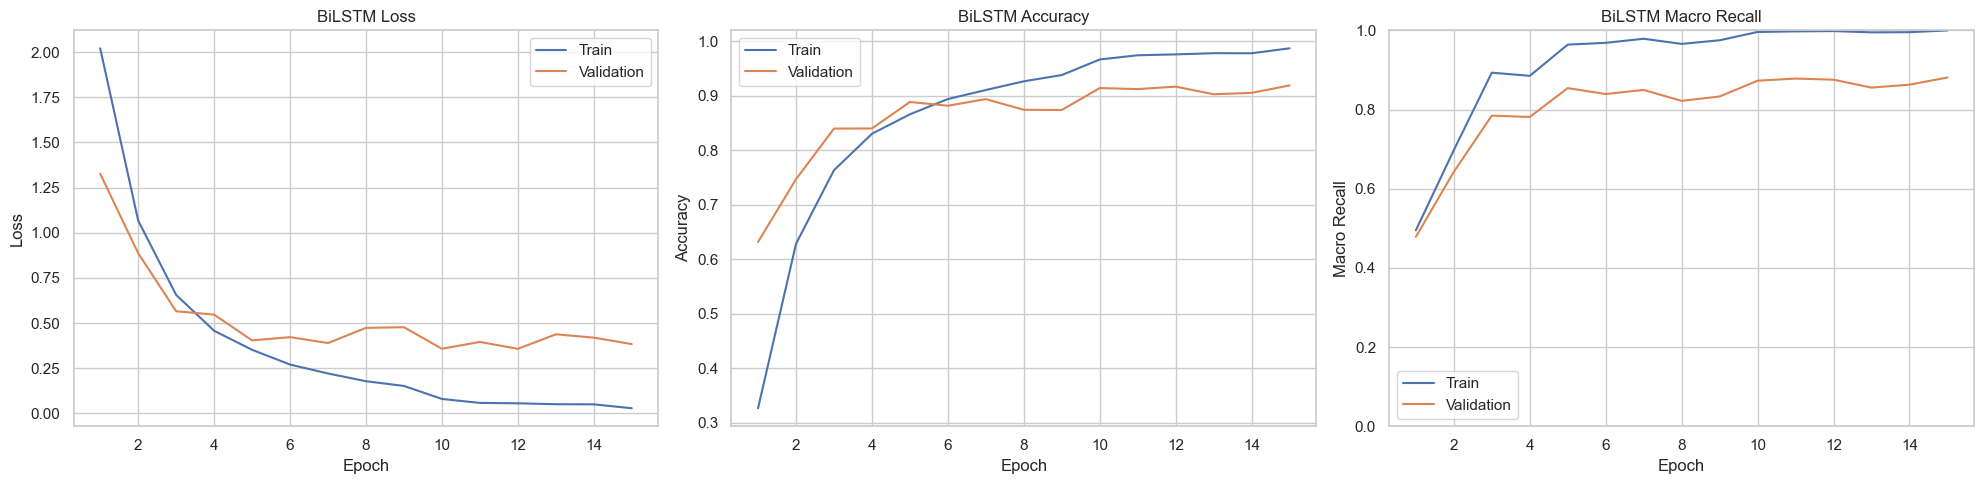

In [28]:

model = build_bilstm_model(len(vocab), RUN_CONFIG['sequence_length'], NUM_CLASSES)
metrics_cb = MetricsCallback(train_texts, train_labels, val_texts, val_labels, RUN_CONFIG['batch_size'])

best_model_path = MODELS_DIR / 'bilstm_closed_best.keras'
callbacks_list = [
    metrics_cb,
    callbacks.ModelCheckpoint(filepath=str(best_model_path), monitor='val_macro_f1', mode='max', save_best_only=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_macro_f1', mode='max', factor=0.5, patience=2, verbose=1),
    callbacks.EarlyStopping(monitor='val_macro_f1', mode='max', patience=4, restore_best_weights=True, verbose=1),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=RUN_CONFIG['epochs'],
    callbacks=callbacks_list,
    class_weight=class_weights_dict,
)

RUN_CONFIG['trained_epochs'] = len(history.history['loss'])
RUN_CONFIG['best_val_macro_f1'] = float(metrics_cb.best_macro_f1)
RUN_CONFIG_PATH.write_text(json.dumps(RUN_CONFIG, indent=2))

last_model_path = MODELS_DIR / 'bilstm_closed_last.keras'
model.save(last_model_path, include_optimizer=False)
print(f"Saved last-epoch model -> {last_model_path}")

history_path = MODELS_DIR / 'bilstm_closed_history.json'
history_payload = {key: [float(v) for v in values] for key, values in history.history.items()}
history_payload['train_macro_recall'] = metrics_cb.history['train_macro_recall']
history_payload['val_macro_recall'] = metrics_cb.history['val_macro_recall']
history_payload['train_macro_f1'] = metrics_cb.history['train_macro_f1']
history_payload['val_macro_f1'] = metrics_cb.history['val_macro_f1']
history_path.write_text(json.dumps(history_payload, indent=2))
print(f"Training history saved -> {history_path}")

plot_learning_curves(history, metrics_cb, title_prefix='BiLSTM')


## Model Evaluation

### Evaluate BiLSTM

Validation classification report (BiLSTM):
              precision    recall  f1-score   support

           0       0.92      0.90      0.91        91
           1       0.67      0.74      0.70        38
           2       0.80      0.95      0.87        21
           3       0.85      0.79      0.82       149
           4       0.79      0.76      0.78        41
           5       0.95      0.98      0.96       691
           6       0.95      0.91      0.93       111
           7       0.87      0.96      0.91        76
           8       0.87      0.87      0.87        39
           9       0.87      0.87      0.87        63
          10       0.93      0.85      0.89        48
          11       0.91      0.96      0.94       269
          12       0.93      0.96      0.94       146
          13       0.79      0.61      0.69        18
          14       0.73      0.80      0.76        66
          15       0.89      0.93      0.91       108
          16       0.93      0.95     

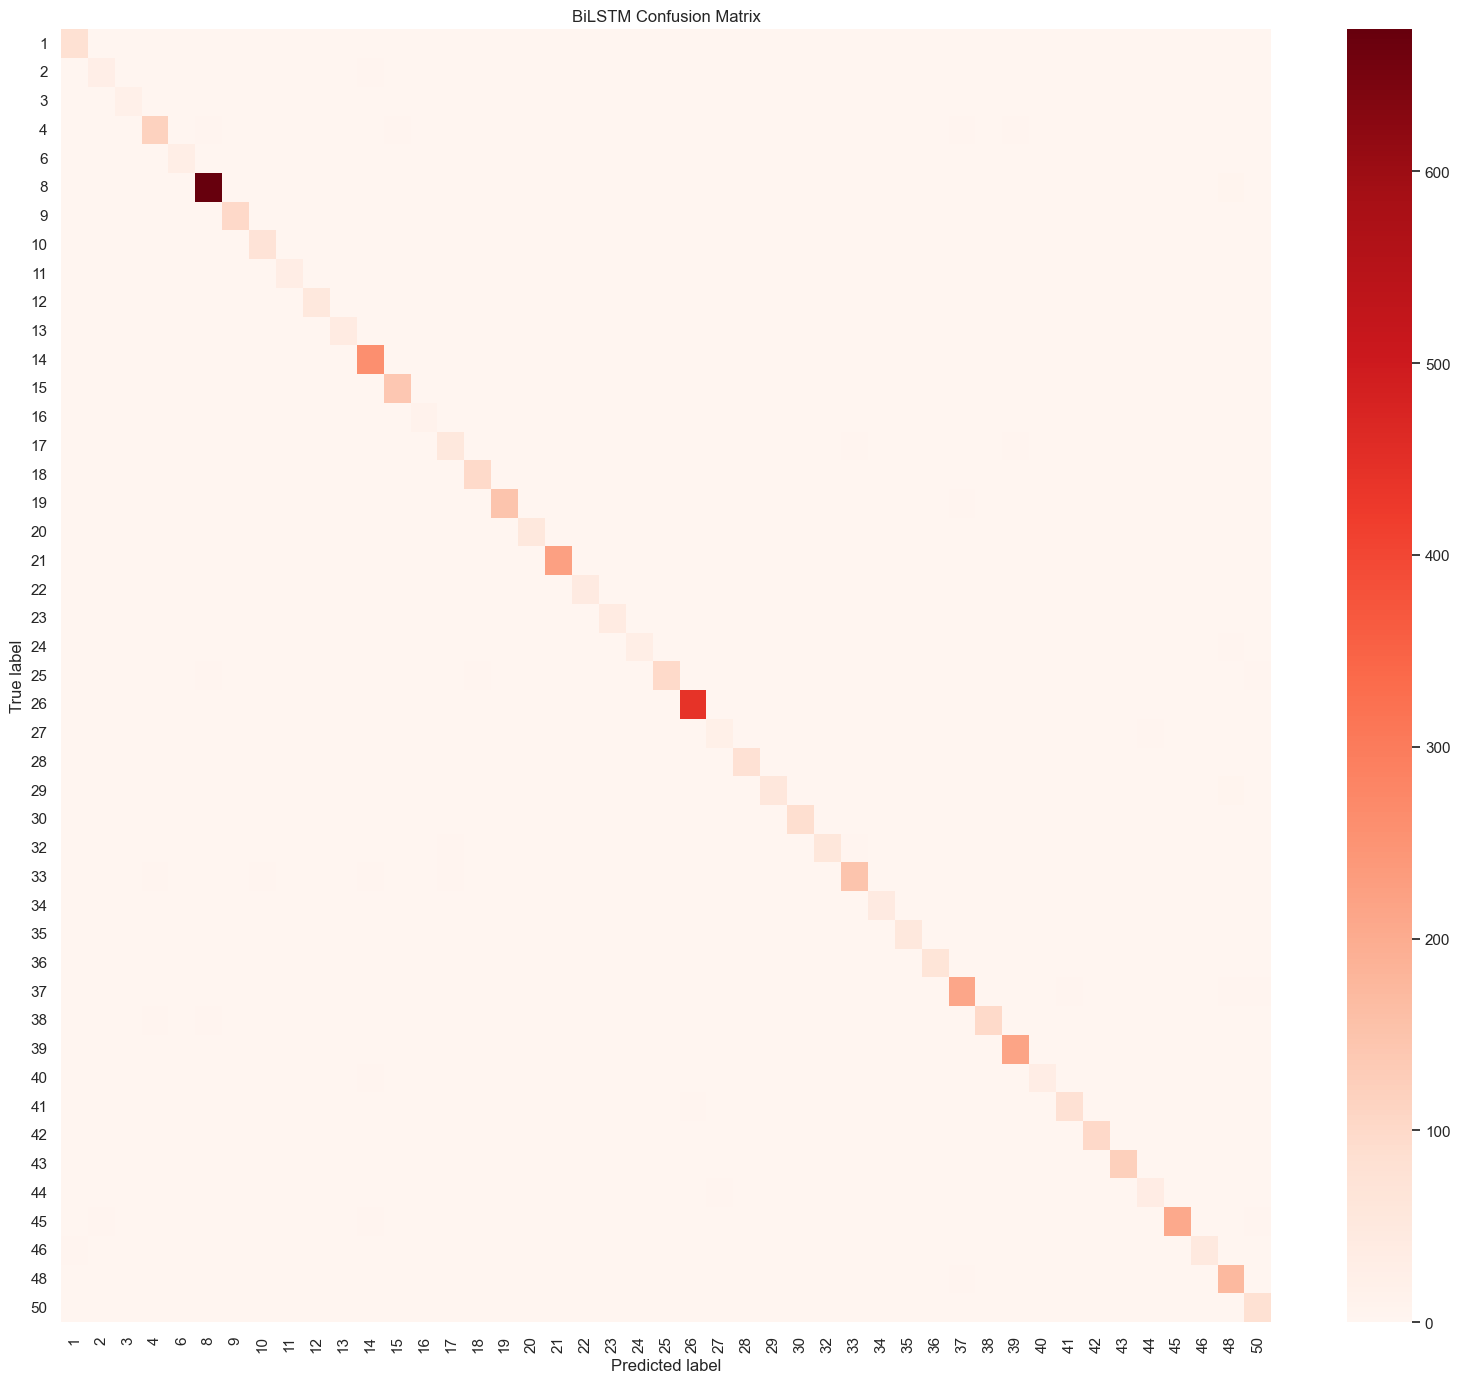

BiLSTM metrics saved -> reports\metrics\bilstm_closed_metrics.json
Validation predictions saved -> artifacts\val_predictions.parquet


In [29]:

best_model = tf.keras.models.load_model(best_model_path)
val_vectors = vectorizer(tf.constant(val_texts))
val_probabilities = best_model.predict(val_vectors, batch_size=RUN_CONFIG['batch_size'], verbose=0)
val_predictions = val_probabilities.argmax(axis=1)

val_accuracy = accuracy_score(val_labels, val_predictions)
val_macro_f1 = f1_score(val_labels, val_predictions, average='macro')
val_macro_recall = recall_score(val_labels, val_predictions, average='macro')
val_macro_precision = precision_score(val_labels, val_predictions, average='macro')
val_top3 = top_k_accuracy_score(val_labels, val_probabilities, k=3)
val_roc_auc = roc_auc_score(label_binarize(val_labels, classes=list(range(NUM_CLASSES))), val_probabilities, average='macro', multi_class='ovr')

print("Validation classification report (BiLSTM):")
print(classification_report(val_labels, val_predictions))

cm_bilstm = plot_conf_matrix(val_labels, val_predictions, LABELS_ORDERED, 'BiLSTM Confusion Matrix')

metrics_payload = {
    'model': 'bilstm',
    'val_accuracy': float(val_accuracy),
    'val_macro_f1': float(val_macro_f1),
    'val_macro_recall': float(val_macro_recall),
    'val_macro_precision': float(val_macro_precision),
    'val_top3_accuracy': float(val_top3),
    'val_roc_auc_macro': float(val_roc_auc),
    'best_val_macro_f1': RUN_CONFIG.get('best_val_macro_f1'),
}
MODEL_RESULTS.append(metrics_payload)

metrics_path = METRICS_DIR / 'bilstm_closed_metrics.json'
metrics_path.write_text(json.dumps({
    **metrics_payload,
    'classification_report': classification_report(val_labels, val_predictions, output_dict=True, zero_division=0),
    'confusion_matrix': cm_bilstm.tolist(),
}, indent=2))
print(f"BiLSTM metrics saved -> {metrics_path}")

val_prediction_rows = pd.DataFrame({
    'text_id': val_df.index,
    'author_true': val_df[AUTHOR_COL].values,
    'author_index_true': val_labels,
    'author_index_pred': val_predictions,
    'author_pred': [index_to_author[int(idx)] for idx in val_predictions],
    'text': val_df[TEXT_COL].values,
    'text_clean': val_df['text_clean'].values,
})
val_prediction_rows.to_parquet(VAL_PREDICTIONS_PATH, index=False)
print(f"Validation predictions saved -> {VAL_PREDICTIONS_PATH}")

BILSTM_ROC_DATA = macro_roc_curve(val_labels, val_probabilities, NUM_CLASSES)


### ROC Curves (Macro-Average)

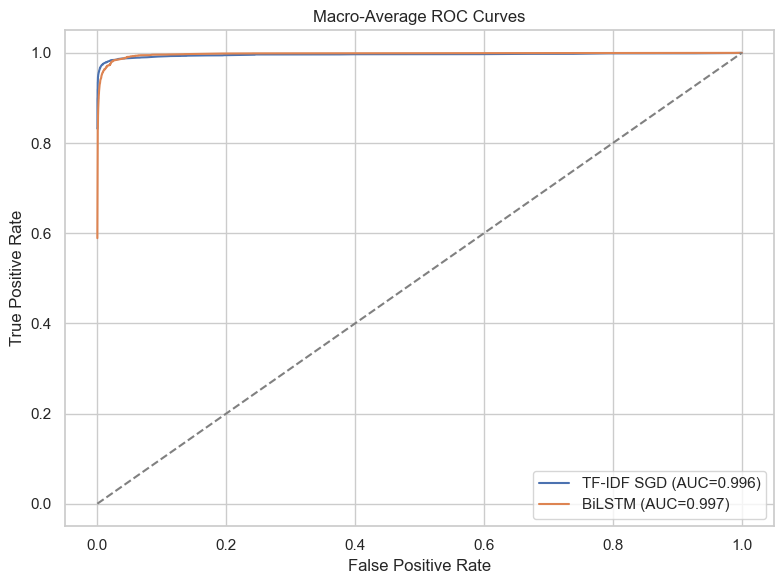

In [30]:

plt.figure(figsize=(8, 6))
if BASELINE_ROC_DATA is not None:
    fpr_base, tpr_base, auc_base = BASELINE_ROC_DATA
    plt.plot(fpr_base, tpr_base, label=f'TF-IDF SGD (AUC={auc_base:.3f})')
if BILSTM_ROC_DATA is not None:
    fpr_bi, tpr_bi, auc_bi = BILSTM_ROC_DATA
    plt.plot(fpr_bi, tpr_bi, label=f'BiLSTM (AUC={auc_bi:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.title('Macro-Average ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Model Comparison & Final Recommendation

In [31]:

results_df = pd.DataFrame(MODEL_RESULTS)
results_df = results_df.sort_values('val_macro_f1', ascending=False).reset_index(drop=True)
print("Validation metrics summary:")
display(results_df)

best_model_name = results_df.iloc[0]['model']
print(f"Recommended model based on macro-F1: {best_model_name}")


Validation metrics summary:


,model,val_accuracy,val_macro_f1,val_macro_recall,val_macro_precision,val_top3_accuracy,val_roc_auc_macro,best_val_macro_f1
0,tfidf_sgd,0.953987,0.944729,0.951442,0.942688,0.978763,0.995923,NaN
1,bilstm,0.919151,0.885990,0.880868,0.894096,0.974478,0.997484,0.88599


Recommended model based on macro-F1: tfidf_sgd
